In [2]:
from graphviz import Digraph

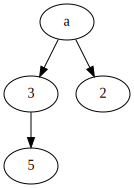

In [3]:
dot = Digraph()
# Add nodes
dot.node('1', label='a')
dot.node('3')
dot.node('2')
dot.node('5')

# Add edges
dot.edges(['12', '13', '35'])

# Visualize the graph
dot